In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# 1. Loading of Dataframes

In [6]:
bin_size = 1000000
matrix_path = f"/labmed/workspace/lotta/finaletoolkit/dataframes_notebook/final_feature_matrix_gc_corrected_{bin_size}.tsv"
df = pd.read_csv(matrix_path, sep="\t")

clinical_path = "/labmed/workspace/lotta/finaletoolkit/dataframes_notebook/filtered_clinical_characteristics.csv"
clinical_df = pd.read_csv(clinical_path)

valid_samples = clinical_df["Extracted_ID"].unique()
df = df[df["sample"].isin(valid_samples)].copy()

print(f"Number of Samples in Matrix: {df['sample'].nunique()}")
print(f"Number of Bins per Sample: {len(df) / df['sample'].nunique()}")

Number of Samples in Matrix: 247
Number of Bins per Sample: 1660.0


# 2. Feature Selektion for LASSO and Pivoting

In [7]:
df["bin_id"] = df["chrom"] + "_" + df["start"].astype(str)

metrics = [
    "mean_gc_corrected", 
   # "median_gc_corrected", 
   #"stdev_gc_corrected", 
    "wps_value_gc_corrected",
   # "min_gc_corrected",
   # "max_gc_corrected",	
]

pivot_df = df.pivot(index="sample", columns="bin_id", values=metrics)

pivot_df.columns = [f"{metric}_{bin_id}" for metric, bin_id in pivot_df.columns]

# Fehlende Werte werden nun später in der Pipeline aufgefüllt, um Data Leakage zu vermeiden
# pivot_df = pivot_df.fillna(pivot_df.median())

print(f"Shape of Feature Matrix: {pivot_df.shape} (Patienten x Features)")
pivot_df.to_csv("/labmed/workspace/lotta/finaletoolkit/dataframes_notebook/pivot_df.csv", index=True)
pivot_df.head()

Shape of Feature Matrix: (247, 3320) (Patienten x Features)


,mean_gc_corrected_chr10_0,mean_gc_corrected_chr10_1000000,mean_gc_corrected_chr10_10000000,mean_gc_corrected_chr10_100000000,mean_gc_corrected_chr10_101000000,mean_gc_corrected_chr10_102000000,mean_gc_corrected_chr10_103000000,mean_gc_corrected_chr10_104000000,mean_gc_corrected_chr10_11000000,mean_gc_corrected_chr10_110000000,...,wps_value_gc_corrected_chr9_89000000,wps_value_gc_corrected_chr9_91000000,wps_value_gc_corrected_chr9_92000000,wps_value_gc_corrected_chr9_93000000,wps_value_gc_corrected_chr9_94000000,wps_value_gc_corrected_chr9_95000000,wps_value_gc_corrected_chr9_96000000,wps_value_gc_corrected_chr9_97000000,wps_value_gc_corrected_chr9_98000000,wps_value_gc_corrected_chr9_99000000
sample,,,,,,,,,,,,,,,,,,,,,
EE85898,172.273991,172.720648,169.257995,167.997867,170.164335,170.633097,165.461570,171.583885,173.160869,171.864133,...,0.012227,-0.016496,-0.177023,0.272642,-0.404030,-0.139032,-0.268932,-0.147145,-0.250653,-0.330485
EE85904,172.222892,167.026441,172.345180,170.705351,169.528536,169.702232,170.576011,175.288459,170.021772,170.013728,...,0.367601,-0.252720,-0.093091,-0.284066,-0.056492,-0.125824,-0.167596,-0.032122,0.058695,-0.286988
EE85905,170.101566,169.211896,170.422985,165.048427,165.526620,167.539141,167.894319,165.445515,168.496828,167.343748,...,-0.110289,-0.307781,0.135058,0.129654,-0.099290,-0.243549,-0.430870,-0.064958,-0.132103,-0.030635
EE85908,169.853406,167.626845,166.278353,166.803115,166.606105,168.438538,165.196924,172.087613,167.282283,167.361284,...,0.087234,0.244812,-0.345297,-0.224018,-0.150926,-0.066989,0.016333,-0.146103,-0.348174,0.102352
EE85918,168.692721,167.376078,171.118393,169.534603,170.150618,168.874179,170.843338,170.072914,169.427424,167.953173,...,-0.498923,-0.025885,-0.173977,0.141373,-0.103935,0.001267,-0.223207,-0.237067,-0.128237,-0.324863


# 3. Stratification

In [8]:
# 3. Labels (y) und Stratifizierung vorbereiten

y = []
strata = []

for sample_id in pivot_df.index:
    row = clinical_df[clinical_df["Extracted_ID"] == sample_id].iloc[0]
    
    is_healthy = row["Patient Type"].lower() == "healthy"
    y.append(0 if is_healthy else 1)
    strata.append(row["Gender"])

y = np.array(y)
X = pivot_df

print(f"Number Cancer: {sum(y)}")
print(f"Number Healthy: {len(y) - sum(y)}")

Number Cancer: 116
Number Healthy: 131


# 4. Split: Train and Test


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 5. LASSO Training mit Cross-Validation und Pipeline


In [10]:
# 5. LASSO Training mit Cross-Validation und Pipeline (Optimierte Version)

# C-Werte: LogisticRegressionCV testet standardmäßig 10 verschiedene C-Werte
# C_values = np.logspace(-4, 4, 100)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('lasso_cv', LogisticRegressionCV(
        Cs=10,                      # Anzahl der zu testenden C-Werte (Standard 10)
        penalty='l1',               # Lasso-Regularisierung
        solver='liblinear',         # Geeignet für l1 und kleine Datensätze
        cv=5,                       # 5-fache Kreuzvalidierung (Standard ist None, wir setzen 5)
        scoring='roc_auc',          # Optimierungsmetrik (ähnlich der Standardwahl in glmnet für binär)
        max_iter=10000,
        random_state=42
    ))
])

# Training der Pipeline. Das Modell findet intern den besten C-Wert
pipeline.fit(X_train, y_train)

best_c = pipeline.named_steps['lasso_cv'].C_[0]
print(f"✅ Bestes C (Inverse Regularisierungsstärke) gefunden durch CV: {best_c:.4f}")

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

print("\n--- Test-Ergebnisse des Optimalen Modells ---")
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

✅ Bestes C (Inverse Regularisierungsstärke) gefunden durch CV: 166.8101

--- Test-Ergebnisse des Optimalen Modells ---
Test Accuracy: 0.78
ROC AUC Score: 0.8405797101449275

Confusion Matrix:
 [[21  6]
 [ 5 18]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.78      0.79        27
           1       0.75      0.78      0.77        23

    accuracy                           0.78        50
   macro avg       0.78      0.78      0.78        50
weighted avg       0.78      0.78      0.78        50



### 5.1 Visualisierung des Parameter-Tunings

Das `LogisticRegressionCV` Modell hat automatisch verschiedene Werte für den Parameter `C` ausprobiert. 
Hier visualisieren wir, wie sich die Genauigkeit des Modells mit `C` verändert.

- **Kleines C**: Starke Regularisierung (Modell wird "gezwungen", einfache Lösungen zu finden). Gefahr von Underfitting.
- **Großes C**: Schwache Regularisierung (Modell darf komplexer sein). Gefahr von Overfitting.
- **Bestes C**: Der Wert, der in der Cross-Validation (CV) die beste Balance und damit den höchsten Score erreicht hat.

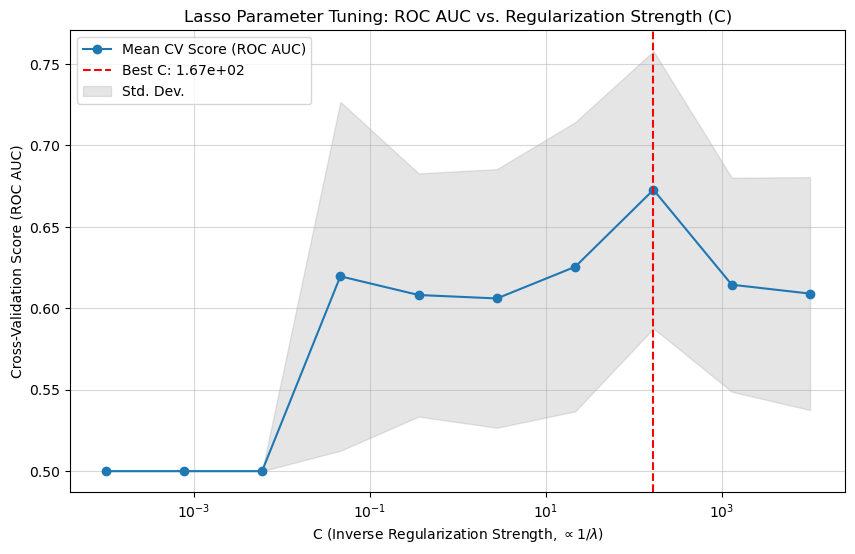

In [ ]:
### 5.1 Visualisierung des Parameter-Tunings

import matplotlib.pyplot as plt

lasso_cv = pipeline.named_steps['lasso_cv']

# Scores extrahieren. Form: (n_folds, n_Cs)
# durchschnitt von allen 5 C-werten (aus den 5 folds)
mean_scores = np.mean(lasso_cv.scores_[1], axis=0)

# standardabweichung, wie weit waren die 5 ergbenisse auseinander, wie groß ist die unsicherheit (später im plot grau markiert)
std_scores = np.std(lasso_cv.scores_[1], axis=0)
cs = lasso_cv.Cs_

plt.figure(figsize=(10, 6))
# semilogx da C typischerweise logarithmisch verteilt ist
plt.semilogx(cs, mean_scores, marker='o', label='Mean CV Score (ROC AUC)')
plt.fill_between(cs, mean_scores - std_scores, mean_scores + std_scores, alpha=0.2, color='gray', label='Std. Dev.')

#bestes C
plt.axvline(lasso_cv.C_[0], linestyle='--', color='r', label=f'Best C: {lasso_cv.C_[0]:.2e}')

plt.title("Lasso Parameter Tuning: ROC AUC vs. Regularization Strength (C)")
plt.xlabel("C (Inverse Regularization Strength, $\propto 1/\lambda$)")
plt.ylabel("Cross-Validation Score (ROC AUC)")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

## 5.2 ROC Curve

The Reciever operating characteristic curve plots the true positive (TP) rate versus the false positive (FP) rate at different classification thresholds. 

The thresholds are different probability cutoffs that separate the two classes in binary classification. It uses probability to tell us how well a model separates the classes.

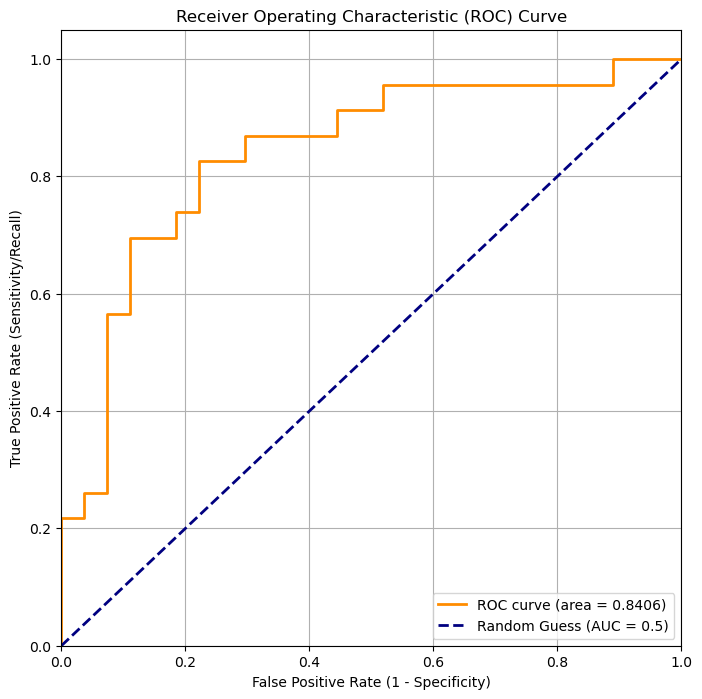

Bestätigter ROC AUC Score: 0.8406


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))

plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (area = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random Guess (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title(f'Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Confirmed ROC AUC Score: {roc_auc:.4f}")

# 6. Selected Features

In [13]:
# 6. Selected Features
# Zugriff auf das LogisticRegressionCV-Modell in der Pipeline
lasso_model = pipeline.named_steps['lasso_cv']

coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lasso_model.coef_[0]
})
# Filtere Features, die NICHT 0 sind
important_features = coef_df[coef_df["Coefficient"] != 0].sort_values(by="Coefficient", ascending=False)

print(f"Number of Important Features: {len(important_features)}")
print("\nTop Features (Positive = Indikative for Cancer, Negative = Indikative for Healthy):")
important_features.head(20)

Number of Important Features: 535

Top Features (Positive = Indikative for Cancer, Negative = Indikative for Healthy):


,Feature,Coefficient
2222,wps_value_gc_corrected_chr18_3000000,0.687110
2255,wps_value_gc_corrected_chr19_13000000,0.405846
3144,wps_value_gc_corrected_chr7_24000000,0.402096
2457,wps_value_gc_corrected_chr20_18000000,0.387693
1576,mean_gc_corrected_chr8_73000000,0.379878
3164,wps_value_gc_corrected_chr7_63000000,0.361446
3035,wps_value_gc_corrected_chr6_165000000,0.356282
2194,wps_value_gc_corrected_chr17_62000000,0.351435
2948,wps_value_gc_corrected_chr5_178000000,0.346751
3239,wps_value_gc_corrected_chr8_8000000,0.345550
